### Goals

Debug the current svm pipeline by 
1) Loading the data in the same way and plotting it
2) fiddling with hyperparams

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj
from datasets import load_from_disk
import yaml
from scipy import stats


from typing import Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys

# import ../utils

sys.path.append('../')

from utils import reflect_points_to_left, get_colormap, generate_distinct_colors



In [2]:
root_path = os.environ["ROOT_DATA_PATH"]
ccf_files_path = os.path.join(root_path, "CCF_files")



In [3]:

space = "flatmap_butterfly"
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,f"{space}.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)
bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()


# move up the hierarchy to get rid of the smallest 'areas' which are actually layers
with open('../../data/files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('../../data/files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name




In [4]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [5]:
animals = ["filt_neurons_D076_1L_CCFv2_newtypes.h5ad",
    "filt_neurons_D077_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D077_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D078_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D078_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D079_3L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D079_4L_CCFv2_newtypes.h5ad"
    ]


In [6]:
ann_path = "../../data/anndatas"
ann_files = [ad.read_h5ad(os.path.join(ann_path, f)) for f in animals]

for i, adata in enumerate(ann_files):
    subcortical_mask = np.isnan(adata.obsm['CCF_streamlines']).any(axis=1)
    adata = adata[~subcortical_mask]


    adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
    adata.obs['area_name'] = adata.obs['area_label'].map(area_class2area_name).astype('category')

    nonzero_counts_mask = np.sum(adata.X, axis=1) > 10
    adata = adata[nonzero_counts_mask]
    ann_files[i] = adata
    
ann_files[0]

/tmp/ipykernel_2910569/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
/tmp/ipykernel_2910569/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
/tmp/ipykernel_2910569/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
/tmp/ipykernel_2910569/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')


View of AnnData object with n_obs × n_vars = 388342 × 106
    obs: 'angle', 'H1_type', 'CCFname', 'slice', 'CCFparentname', 'id', 'H2_type', 'CCFano', 'H3_type', 'area_label', 'area_name'
    uns: 'H2_type_id', 'H3_type_id', 'brain_idx', 'genes', 'slices_to_remove'
    obsm: 'CCF', 'CCF_streamlines', 'depth', 'pos', 'pos40x'

In [7]:
ann_files[0].obs['H2_type'].value_counts()

types_of_interest = ['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L5 ET', 'L6 IT', 'L6 CT']
types_of_interest = [ 'L4/5 IT', 'L5 IT', ]

for i, adata in enumerate(ann_files):
    adata.obs['H2_type_of_interest'] = adata.obs['H2_type'].apply(lambda x: x if x in types_of_interest else 'Other')
    adata.obs['H2_type_of_interest'] = adata.obs['H2_type_of_interest'].astype('category')
    
    adata.obs['H3_type_of_interest'] = adata.obs['H3_type'].apply(lambda x: x if any([(t in x) for t in types_of_interest]) else 'Other')
    adata.obs['H3_type_of_interest'] = adata.obs['H3_type_of_interest'].astype('category')

    ann_files[i] = adata

/tmp/ipykernel_2910569/3479338797.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['H2_type_of_interest'] = adata.obs['H2_type'].apply(lambda x: x if x in types_of_interest else 'Other')
/tmp/ipykernel_2910569/3479338797.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['H2_type_of_interest'] = adata.obs['H2_type'].apply(lambda x: x if x in types_of_interest else 'Other')
/tmp/ipykernel_2910569/3479338797.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['H2_type_of_interest'] = adata.obs['H2_type'].apply(lambda x: x if x in types_of_interest else 'Other')
/tmp/ipykernel_2910569/3479338797.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['H2_type_of_interest'] = adata.obs['H2_type'].apply(lambda x: x if x in type

## Plot a specified line in ccf streamlines space

In [ ]:
from typing import Tuple, Optional, Union, Dict, Any, List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Colormap
import seaborn as sns
import pandas as pd

def plot_rectangular_volume(
    adata, 
    start: Tuple[float, float], 
    end: Tuple[float, float], 
    thickness: float, 
    *, 
    color_by: Optional[str] = None,
    cmap: Union[str, Colormap] = "viridis",
    figsize: Tuple[int, int] = (10, 6),
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None,
    point_size: int = 30,
    alpha: float = 0.7,
    debug: bool = False,
    debug_figsize: Tuple[int, int] = (8, 8),
    boundaries: Optional[Dict[Any, np.ndarray]] = None,
    boundary_intersection_epsilon: float = 0.1,
    boundary_line_style: str = "k:",
    boundary_line_width: float = 1.0,
    legend: bool = True,
) -> Union[plt.Axes, Tuple[plt.Axes, plt.Axes]]:
    """
    Plot a cross-section of 3D data along a line in the xy-plane with boundary intersections.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object containing the 3D coordinates in `.obsm['CCF_streamlines']`.
    start : Tuple[float, float]
        (x, y) coordinates of the starting point of the line.
    end : Tuple[float, float]
        (x, y) coordinates of the ending point of the line.
    thickness : float
        Maximum perpendicular distance from the line for points to be included.
    color_by : Optional[str], default=None
        Column name in `adata.obs` to use for coloring points. Must be categorical.
    cmap : Union[str, Colormap], default="viridis"
        Colormap to use when color_by is not provided. Can be any valid matplotlib colormap.
    figsize : Tuple[int, int], default=(10, 6)
        Figure size as (width, height) in inches for the main plot.
    ax : Optional[plt.Axes], default=None
        Matplotlib axes to plot on. If None, a new figure is created.
    title : Optional[str], default=None
        Title for the plot. If None, a default title is generated.
    point_size : int, default=30
        Size of scatter points.
    alpha : float, default=0.7
        Transparency of scatter points.
    debug : bool, default=False
        If True, creates an additional plot showing the points in the xy plane
        with the rectangle region highlighted.
    debug_figsize : Tuple[int, int], default=(8, 8)
        Figure size for the debug plot.
    boundaries : Optional[Dict[Any, np.ndarray]], default=None
        Dictionary of boundary coordinates to plot on debug view and detect intersections.
        Each value should be a numpy array of shape (n, 2) containing x,y coordinates.
    boundary_intersection_epsilon : float, default=0.1
        Maximum distance for a boundary point to be considered as intersecting with the line.
    boundary_line_style : str, default="k:"
        Line style for the intersection markers (vertical lines).
    boundary_line_width : float, default=1.0
        Line width for the intersection markers.
        
    Returns
    -------
    Union[plt.Axes, Tuple[plt.Axes, plt.Axes]]
        Either the main plot axes or a tuple of (main_axes, debug_axes) if debug=True.
        
    Raises
    ------
    ValueError
        If start and end points are identical or if color_by column is not found.
    """
    # Get 3D coordinates from AnnData object
    xyz = adata.obsm['CCF_streamlines']
    xyz = reflect_points_to_left(xyz)
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    # Extract start and end coordinates
    start_x, start_y = start
    end_x, end_y = end
    
    # Compute line vector and length
    line_vec = np.array([end_x - start_x, end_y - start_y])
    line_length = np.linalg.norm(line_vec)
    
    if line_length == 0:
        raise ValueError("Start and end points must be different")
    
    # Normalize to unit vector
    unit_vec = line_vec / line_length
    
    # Compute perpendicular unit vector (90 degrees rotation)
    perp_vec = np.array([-unit_vec[1], unit_vec[0]])
    
    # Calculate vectors from start point to each data point
    point_vecs = np.column_stack((x - start_x, y - start_y))
    
    # Project each point onto the line
    projections = np.dot(point_vecs, unit_vec)
    
    # Calculate perpendicular distances
    perp_distances = np.abs(np.dot(point_vecs, perp_vec))
    
    # Keep projections within the line segment
    in_range = (projections >= 0) & (projections <= line_length)
    
    # Filter points within thickness
    within_thickness = perp_distances <= thickness
    
    # Combined mask for points in the rectangular volume
    mask = in_range & within_thickness
    
    # Filter data
    filtered_projections = projections[mask]
    filtered_z = z[mask]
    
    # Prepare the plot data
    plot_data = {
        'Distance_Along_Line': filtered_projections,
        'Z_Coordinate': filtered_z,
        'Perpendicular_Distance': perp_distances[mask]
    }
    
    # Handle coloring by categorical variable
    if color_by is not None:
        if color_by not in adata.obs.columns:
            raise ValueError(f"Column '{color_by}' not found in adata.obs")
        
        # Extract categories for filtered points
        categories = adata.obs[color_by].values[mask]
        plot_data['Category'] = categories

    # Create DataFrame for plotting
    plot_df = pd.DataFrame(plot_data)
    
    # Create or use provided axes
    if ax is None:
        main_fig, ax = plt.subplots(figsize=figsize)
    else:
        main_fig = ax.figure
    
    # Create the main scatter plot
    if color_by is not None:
        sns.scatterplot(
            data=plot_df,
            x='Distance_Along_Line',
            y='Z_Coordinate',
            hue='Category',
            s=point_size,
            alpha=alpha,
            ax=ax,
            palette=cmap
        )
    else:
        sns.scatterplot(
            data=plot_df,
            x='Distance_Along_Line',
            y='Z_Coordinate',
            hue='Perpendicular_Distance',
            palette=cmap,
            s=point_size,
            alpha=alpha,
            ax=ax
        )
        # Update legend title
        if ax.get_legend() is not None:
            ax.get_legend().set_title('Distance from Line')

    # remove legend
    if not legend:
        ax.get_legend().remove()

    # place legend outside to the right
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # reverse y axis
    ax.invert_yaxis()

    
    # Find boundary intersections if boundaries are provided
    boundary_intersections: List[float] = []
    if boundaries is not None:
        # Collect all boundary points
        all_boundary_points = []
        for boundary_coords in boundaries.values():
            all_boundary_points.append(boundary_coords)
        
        if all_boundary_points:
            # Concatenate all boundary points
            all_points = np.vstack(all_boundary_points)
            
            # Calculate vectors from start point to each boundary point
            boundary_vecs = np.column_stack((all_points[:, 0] - start_x, all_points[:, 1] - start_y))
            
            # Project each boundary point onto the line
            boundary_projections = np.dot(boundary_vecs, unit_vec)
            
            # Calculate perpendicular distances
            boundary_perp_distances = np.abs(np.dot(boundary_vecs, perp_vec))
            
            # Find points that are within epsilon of the line and within the line segment
            boundary_in_range = (boundary_projections >= 0) & (boundary_projections <= line_length)
            boundary_close_to_line = boundary_perp_distances <= boundary_intersection_epsilon
            boundary_intersection_mask = boundary_in_range & boundary_close_to_line
            
            # Get the projections of intersecting boundary points
            boundary_intersections = boundary_projections[boundary_intersection_mask]
            
            # Find unique intersection positions with a small tolerance
            # Group intersections that are very close to each other
            if len(boundary_intersections) > 0:
                boundary_intersections = np.sort(boundary_intersections)
                unique_intersections = [boundary_intersections[0]]
                for dist in boundary_intersections[1:]:
                    if dist - unique_intersections[-1] > boundary_intersection_epsilon:
                        unique_intersections.append(dist)
                boundary_intersections = unique_intersections
    
    # Add vertical lines at boundary intersections
    for intersection_dist in boundary_intersections:
        ax.axvline(
            x=intersection_dist, 
            linestyle=boundary_line_style.lstrip('k'), 
            color='k',
            linewidth=boundary_line_width,
            alpha=0.8,
        )
    
    # Set plot labels and title
    ax.set_xlabel('Distance Along Line (a.u.)')
    ax.set_ylabel('Z Coordinate')
    
    if title is None:
        ax.set_title(f'Cross-section: Points within {thickness} units of line')
    else:
        ax.set_title(title)
    
    # Add text labels for boundary intersections
    if boundary_intersections and len(boundary_intersections) <= 10:  # Only label if not too many
        y_min, y_max = ax.get_ylim()
        for i, intersection_dist in enumerate(boundary_intersections):
            ax.text(
                intersection_dist, 
                y_max - 0.05 * (y_max - y_min),  # Place near top
                f'B{i+1}',
                ha='center',
                va='top',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
            )
    
    plt.tight_layout()
    plt.show()

    
    # Create debug visualization if requested
    if debug:
        debug_fig, debug_ax = plt.subplots(figsize=debug_figsize)
        
        # Plot all points in xy plane
        debug_ax.scatter(x, y, s=point_size/3, alpha=alpha/2, color='gray', label='All Points')
        
        # Highlight points in the rectangular volume
        debug_ax.scatter(x[mask], y[mask], s=point_size, alpha=alpha, 
                        color='blue', label='Selected Points')
        
        # Draw the line from start to end
        debug_ax.plot([start_x, end_x], [start_y, end_y], 'r-', linewidth=2, label='Center Line')

        # Label the start with a green circle
        debug_ax.plot(start_x, start_y, 'go', markersize=8, label='Start Point')
        
        # Draw the rectangular region
        # Calculate the four corners of the rectangle
        corner1 = np.array([start_x, start_y]) + thickness * perp_vec
        corner2 = np.array([start_x, start_y]) - thickness * perp_vec
        corner3 = np.array([end_x, end_y]) - thickness * perp_vec
        corner4 = np.array([end_x, end_y]) + thickness * perp_vec
        
        # Create a polygon patch
        rectangle = patches.Polygon(
            np.array([corner1, corner4, corner3, corner2]), 
            closed=True, 
            fill=True, 
            alpha=0.2, 
            color='red',
            label='Selection Region'
        )
        debug_ax.add_patch(rectangle)
        
        # Plot boundaries if provided
        if boundaries is not None:
            for k, boundary_coords in boundaries.items():
                debug_ax.plot(*boundary_coords.T, c="k", lw=0.5)
            
            # Mark intersection points on the debug plot
            for i, intersection_dist in enumerate(boundary_intersections):
                # Calculate the point coordinates
                intersection_point = np.array([start_x, start_y]) + intersection_dist * unit_vec
                debug_ax.plot(
                    intersection_point[0],
                    intersection_point[1],
                    'o',
                    color='red',
                    markersize=6,
                    markeredgecolor='black',
                    alpha=0.8
                )
                debug_ax.text(
                    intersection_point[0],
                    intersection_point[1],
                    f'B{i+1}',
                    fontsize=8,
                    ha='center',
                    va='bottom',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                )
        
        # Set labels and title for debug plot
        debug_ax.set_xlabel('X Coordinate')
        debug_ax.set_ylabel('Y Coordinate')
        debug_ax.set_title('XY Plane View with Selection Region')
        debug_ax.legend(loc='best')
        debug_ax.set_aspect('equal')
        
        # Add gridlines
        debug_ax.grid(True, linestyle='--', alpha=0.7)
        
        debug_ax.grid(True, linestyle='--', alpha=0.7)   
        for k, boundary_coords in bf_left_boundaries_flat.items():
            debug_ax.plot(*boundary_coords.T, c="k", lw=0.5)
        # debug_ax.axis('off')
        debug_ax.set_aspect('equal')
        debug_ax.set_ylim(debug_ax.get_ylim()[::-1])
        
        plt.tight_layout()
        plt.show()


predicted boundary is left of the actual boundary for 1, right for 2


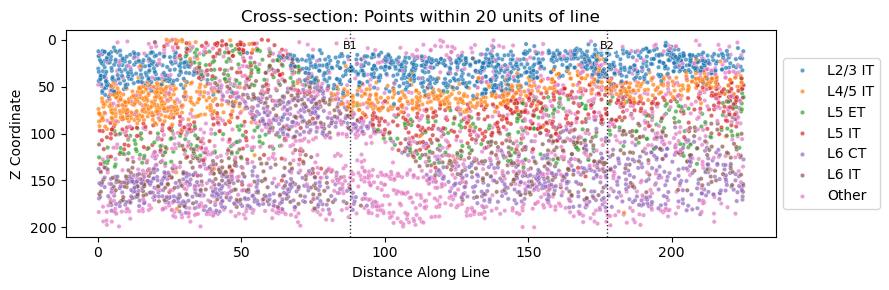

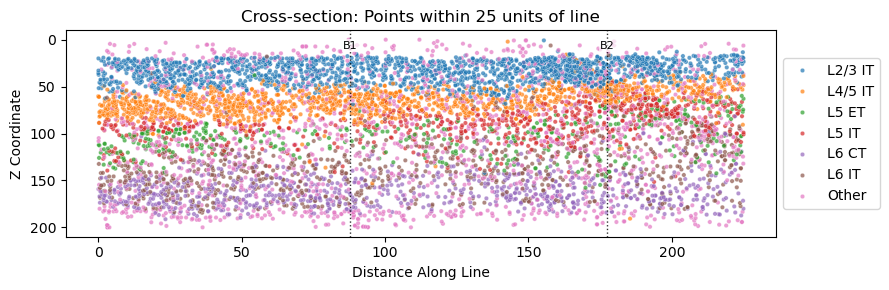

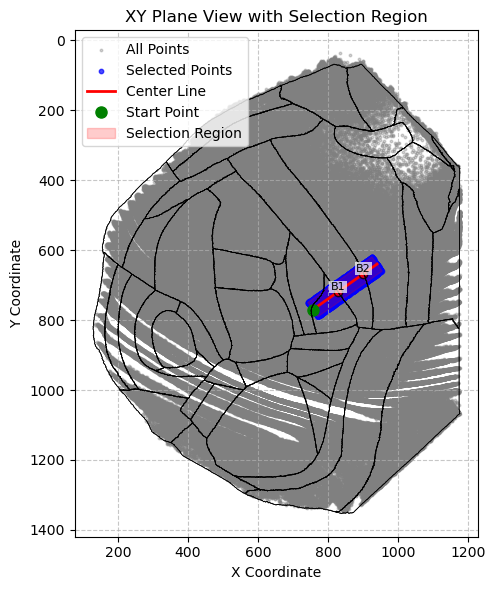

predicted boundary is left of the actual boundary for 1, right for 2


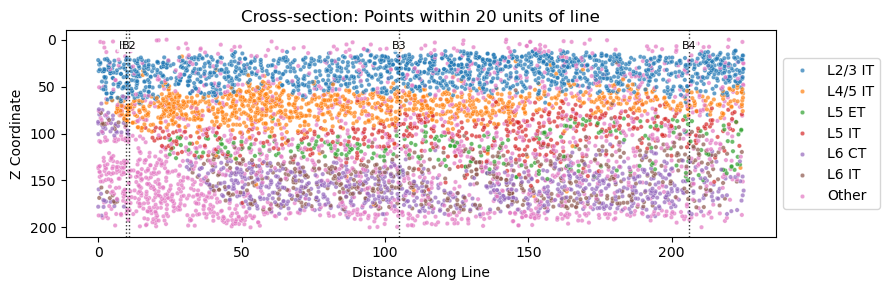

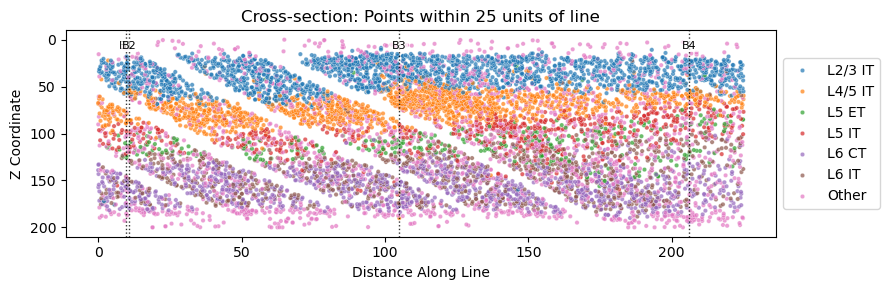

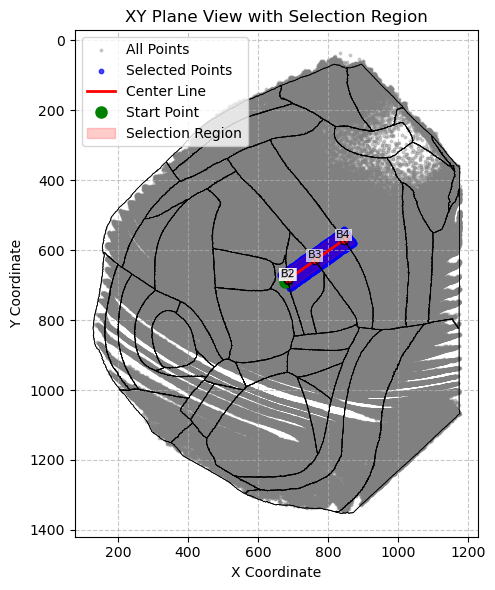

predicted boundary is left of the actual boundary for 1, right for 2


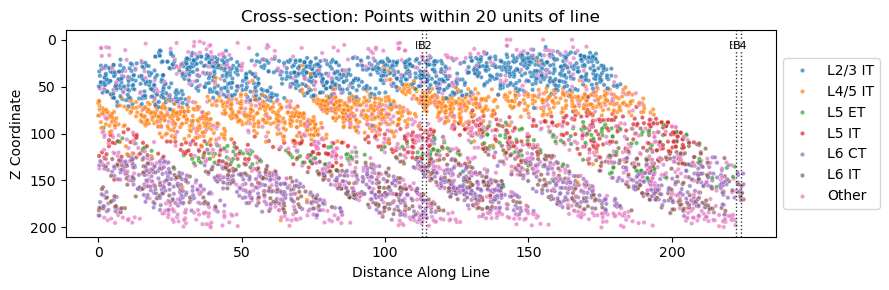

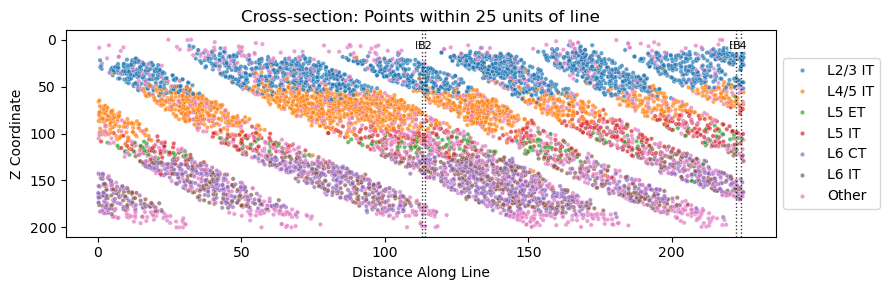

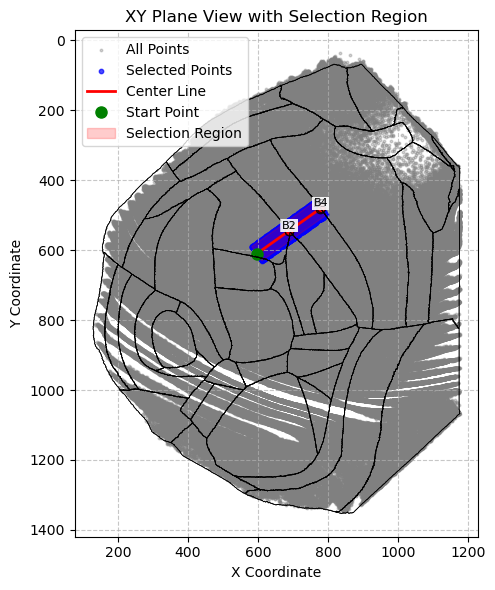

predicted boundary is left of the actual boundary for 1, right for 2


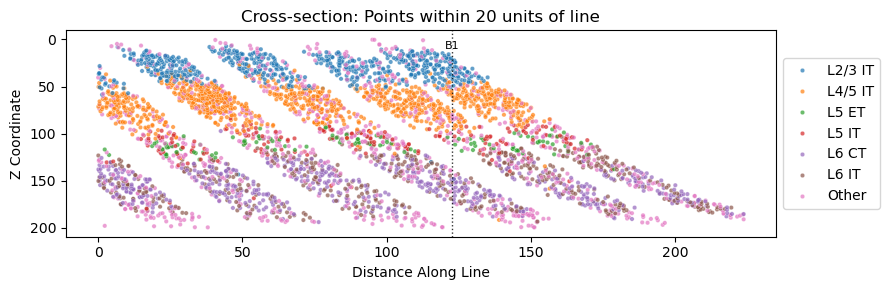

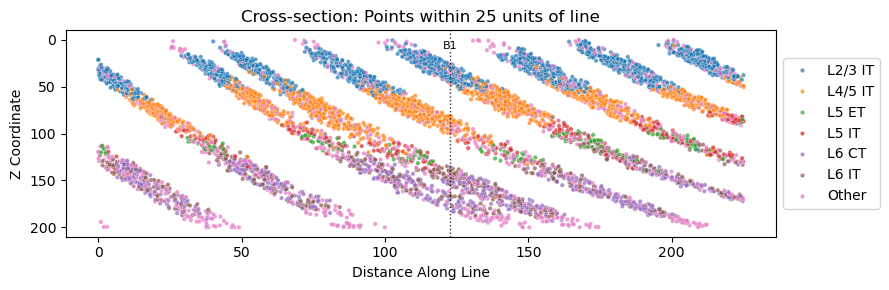

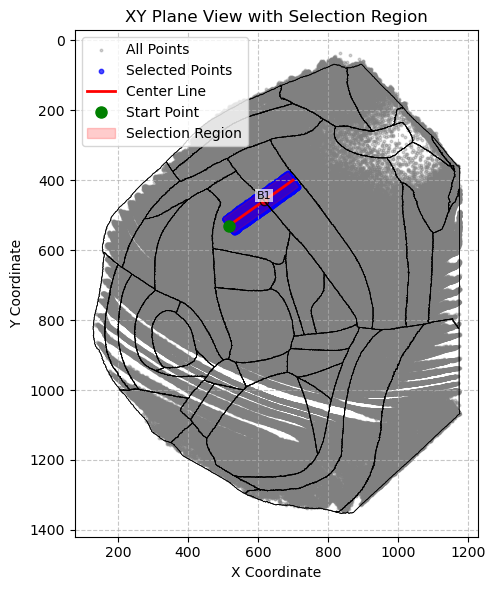

predicted boundary is left of the actual boundary for 1, right for 2


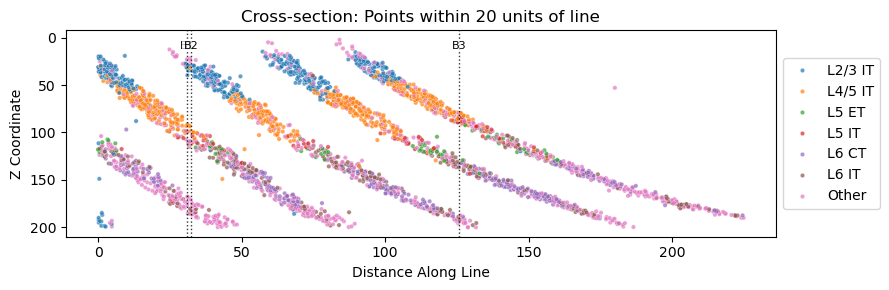

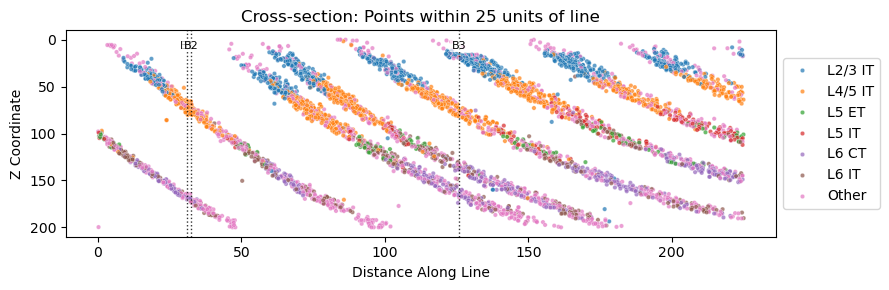

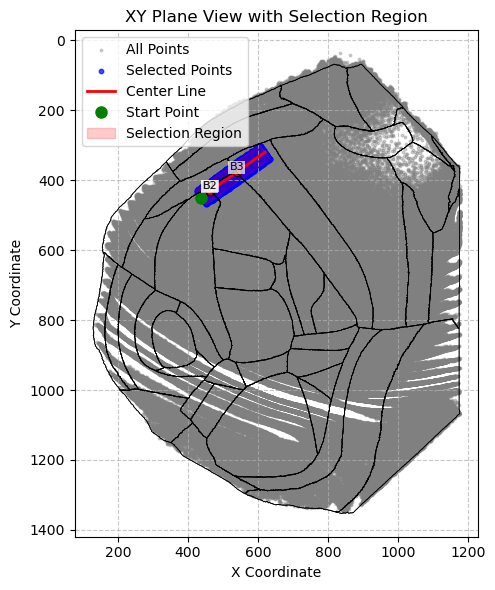

In [116]:
col = 'H2_type_of_interest'
cmap = generate_distinct_colors(len(np.unique(ann_files[0].obs[col])), return_cmap=False)

for offset in np.arange(-40, 300, 80):
    p1 = (716.48300834 - offset,  730.37073235-offset)
    p2 = (900 - offset, 600-offset)
    print("predicted boundary is left of the actual boundary for 1, right for 2")
    plot_rectangular_volume(ann_files[1], p1, p2, 20, color_by=col, point_size=10, debug=False, cmap=cmap, figsize=(9,3), debug_figsize=(8,8),
                            boundaries=bf_left_boundaries_flat, boundary_intersection_epsilon=1)
    # plot_rectangular_volume(ann_files[1], p1, p2, 20, color_by="area_name", point_size=10, debug=False, cmap=cmap, figsize=(10,3), debug_figsize=(3,3)
    #                         ,boundaries=bf_left_boundaries_flat)


    plot_rectangular_volume(ann_files[2], p1, p2, 25, color_by=col, point_size=10, debug=True, cmap=cmap, figsize=(9,3), debug_figsize=(6,6),
                            boundaries=bf_left_boundaries_flat, boundary_intersection_epsilon=1)
    # plot_rectangular_volume(ann_files[2], p1, p2, 20, color_by="area_name", point_size=10, debug=False, cmap=cmap, figsize=(10,3), debug_figsize=(3,3))

## Plot the actual slices with cell type

In [25]:

def plot_slices_by_celltype(
    adata: ad.AnnData,
    slice_num,
    figsize = (10, 10),
    dpi: int = 100,
    color_map = None,
    color_by = 'H2_type',
):
    """
    Plot each slice with cells colored by H2_type.
    
    Args:
        adata: AnnData object containing spatial data
        output_dir: Directory to save output plots (if None, plots are not saved)
        figsize: Figure dimensions (width, height)
        dpi: Figure resolution
        palette: Color palette to use for cell types
        
    Returns:
        Dict mapping slice numbers to matplotlib figure objects
    """
    
    # Get unique slices and H2 types
    cell_types = adata.obs[color_by].unique()
    areas = adata.obs['area_label'].unique()
    
    # Create custom color palette if not specified
    if color_map is None:
        palette = sns.color_palette("tab20", n_colors=len(cell_types))
    
        # Create color mapping
        color_map = dict(zip(cell_types, palette))

    area_color_palette = sns.color_palette("tab20", n_colors=len(areas))
    area_color_map = dict(zip(areas, area_color_palette))
        

    # Subset data for this slice
    slice_data = adata[adata.obs['slice'] == slice_num]
    
    # Create figure
    fig, ax = plt.subplots(1,4,figsize=figsize, dpi=dpi)
    
    # Extract coordinates
    x = slice_data.obsm['pos'][:, 0]
    y = slice_data.obsm['pos'][:, 1]
    cell_types = slice_data.obs[color_by]


    anno = slice_data.obs['area_label']
    
    # Create scatter plot with Seaborn
    sns.scatterplot(
        x=x, 
        y=y,
        hue=cell_types,
        palette=color_map,
        s=5,  # Point size
        alpha=0.7,  # Transparency
        linewidth=0,
        ax=ax[0]
    )

    # Formatting
    ax[0].set_title(f"Brain Slice {slice_num}")
    ax[0].set_xlabel("X Position")
    ax[0].set_ylabel("Y Position")
    # ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cell Type')
    ax[0].legend().remove()
    ax[0].set_aspect('equal')
    ax[0].axis('off')

    sns.scatterplot(
        x=x, 
        y=y,
        hue=anno,
        palette=area_color_map,
        s=5,  # Point size
        alpha=0.7,  # Transparency
        linewidth=0,
        ax=ax[2]
    )
    ax[2].legend().remove()
    ax[2].set_aspect('equal')
    ax[2].axis('off')

    xyz = slice_data.obsm['CCF_streamlines']
    xyz = reflect_points_to_left(xyz)
    x_ccf = xyz[:, 0]
    z_ccf = xyz[:, 2]
    y_ccf = xyz[:, 1]

    x = adata.obsm['CCF_streamlines'][:, 0]
    y = adata.obsm['CCF_streamlines'][:, 1]
    labels = adata.obs['area_label']
    colors_labels = np.array([area_color_map[label] for label in labels])
    ax[1].scatter(x, y, color=colors_labels, alpha=0.002, linewidths=0, s=3)

    ax[1].scatter(x_ccf, y_ccf, s=1, c='r')
    
    ax[1].grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        ax[1].plot(*boundary_coords.T, c="k", lw=0.5)
    ax[1].axis('off')
    ax[1].set_aspect('equal')
    ax[1].set_ylim(ax[1].get_ylim()[::-1])

    sns.scatterplot(
        x=x_ccf, 
        y=z_ccf,
        hue=anno,
        palette=area_color_map,
        s=5,  # Point size
        alpha=0.7,  # Transparency
        linewidth=0,
        ax=ax[3])
    
    sns.scatterplot(
        x=x_ccf, 
        y=z_ccf+500,
            hue=cell_types,
        palette=color_map,
        s=5,  # Point size
        alpha=0.7,  # Transparency
        linewidth=0,
        ax=ax[3])
    ax[3].legend().remove()
    ax[3].set_aspect('equal')
    ax[3].axis('off')        # Improve aesthetics
    sns.despine(fig=fig)
    plt.tight_layout()
    plt.savefig(f"slice_{slice_num}_analysis.png", dpi=dpi)
    plt.show()        

def plot_density_by_celltype(
    adata: ad.AnnData,
    slice_num,
    figsize = (10, 10),
    dpi: int = 100,
    color_map = None,
    color_by = 'H2_type',
    with_points: bool = False,
):
    """
    Plot each slice with cells colored by H2_type.
    
    Args:
        adata: AnnData object containing spatial data
        output_dir: Directory to save output plots (if None, plots are not saved)
        figsize: Figure dimensions (width, height)
        dpi: Figure resolution
        palette: Color palette to use for cell types
        
    Returns:
        Dict mapping slice numbers to matplotlib figure objects
    """
    
    # Get unique slices and H2 types
    cell_types = adata.obs[color_by].unique()
    areas = adata.obs['area_label'].unique()
    
    # Create custom color palette if not specified
    if color_map is None:
        palette = sns.color_palette("tab20", n_colors=len(cell_types))
    
        # Create color mapping
        color_map = dict(zip(cell_types, palette))

    area_color_palette = sns.color_palette("tab20", n_colors=len(areas))
    area_color_map = dict(zip(areas, area_color_palette))


    # Subset data for this slice
    slice_data = adata[adata.obs['slice'] == slice_num] 
    xyz = slice_data.obsm['CCF_streamlines']
    xyz = reflect_points_to_left(xyz)
    x_ccf = xyz[:, 0]
    z_ccf = xyz[:, 2]


    labels = adata.obs['area_label']
    anno = slice_data.obs['area_label']
    cell_types = slice_data.obs[color_by]

    # Add KDE plot of x-axis density, colored by cell type
    f, ax = plt.subplots(2,1, figsize=figsize)
    for cell_type in np.unique(cell_types):
        if cell_type=='Other':
            continue
        mask = cell_types == cell_type
        sns.kdeplot(
            x=x_ccf[mask],
            color=np.mean([color_map[k] for k in color_map.keys() if (cell_type in k)], axis=0),  # Average color for 'L4/5 IT' in the 4th cmap
            fill=True,
            alpha=0.3,
            label=cell_type,
            ax=ax[0],
            common_norm=False,
            bw_adjust=0.1  # Adjust bandwidth as needed
        )
    ax[0].legend(title='Cell Type', loc='upper right')
    ax[0].set_xlabel('Distance along slice (a.u.)')
    if with_points:
        sns.scatterplot(
            x=x_ccf, 
            y=z_ccf,
            hue=anno,
            palette=area_color_map,
            s=5,  # Point size
            alpha=0.7,  # Transparency
            linewidth=0,
            ax=ax[1])
        ax[1].legend().remove()
    else:
        cell_type_names = np.unique(cell_types)
        
        # Calculate KDE for both cell types on same x grid
        x_grid = np.linspace(min(x_ccf), max(x_ccf), 500)
        kde1 = stats.gaussian_kde(x_ccf[cell_types == cell_type_names[0]], bw_method=0.1)
        kde2 = stats.gaussian_kde(x_ccf[cell_types == cell_type_names[1]], bw_method=0.1)

        density1 = kde1(x_grid)
        density2 = kde2(x_grid)

        # Calculate ratio (with small epsilon to avoid division by zero)
        epsilon = 1e-10
        ratio = (density1 - density2) / (density1 + density2 + epsilon)  # Normalized difference

        # Plot ratio on secondary axis
        ax[1].plot(x_grid, ratio, 'k-', linewidth=1.5, label='Ratio')
        ax[1].set_ylabel('Ratio (L4/5 IT / L5 IT)')
        ax[1].legend(loc='upper right')
    # ax[1].axis('off')     
    plt.tight_layout()
    plt.savefig(f"slice_{slice_num}_density.pdf", dpi=dpi)
    plt.show()

In [ ]:
adata = ann_files[0]
color_by='H3_type'  
slice_num = 23


cell_types = adata.obs[color_by].unique()
areas = adata.obs['area_label'].unique()

# Create custom color palette if not specified
if color_map is None:
    palette = sns.color_palette("tab20", n_colors=len(cell_types))

    # Create color mapping
    color_map = dict(zip(cell_types, palette))

area_color_palette = sns.color_palette("tab20", n_colors=len(areas))
area_color_map = dict(zip(areas, area_color_palette))
    

# Subset data for this slice
slice_data = adata[adata.obs['slice'] == slice_num]

# Create figure
fig, ax = plt.subplots(1,4,figsize=figsize, dpi=dpi)

# Extract coordinates
x = slice_data.obsm['pos'][:, 0]
y = slice_data.obsm['pos'][:, 1]
cell_types = slice_data.obs[color_by]

AnnData object with n_obs × n_vars = 388342 × 106
    obs: 'angle', 'H1_type', 'CCFname', 'slice', 'CCFparentname', 'id', 'H2_type', 'CCFano', 'H3_type', 'area_label', 'area_name', 'H2_type_of_interest', 'H3_type_of_interest'
    uns: 'H2_type_id', 'H3_type_id', 'brain_idx', 'genes', 'slices_to_remove'
    obsm: 'CCF', 'CCF_streamlines', 'depth', 'pos', 'pos40x'

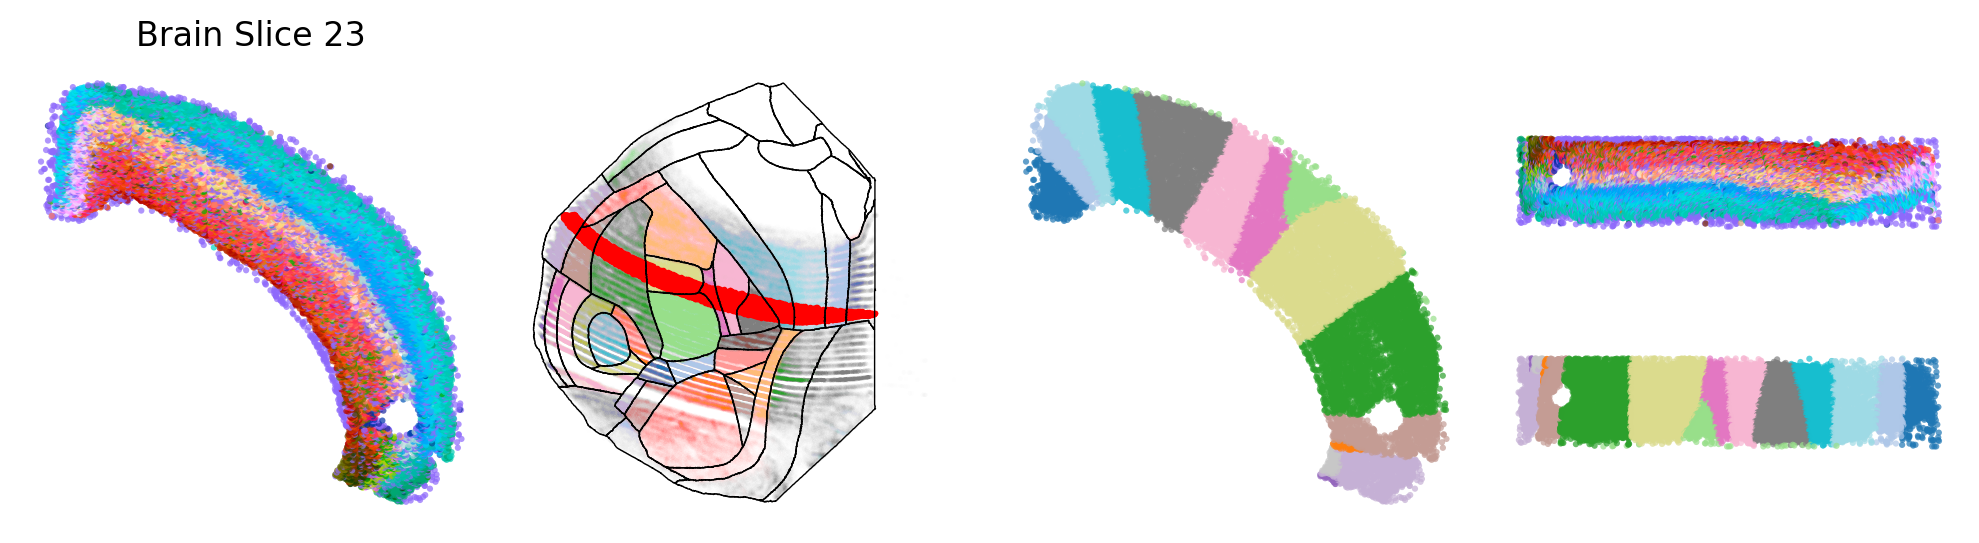

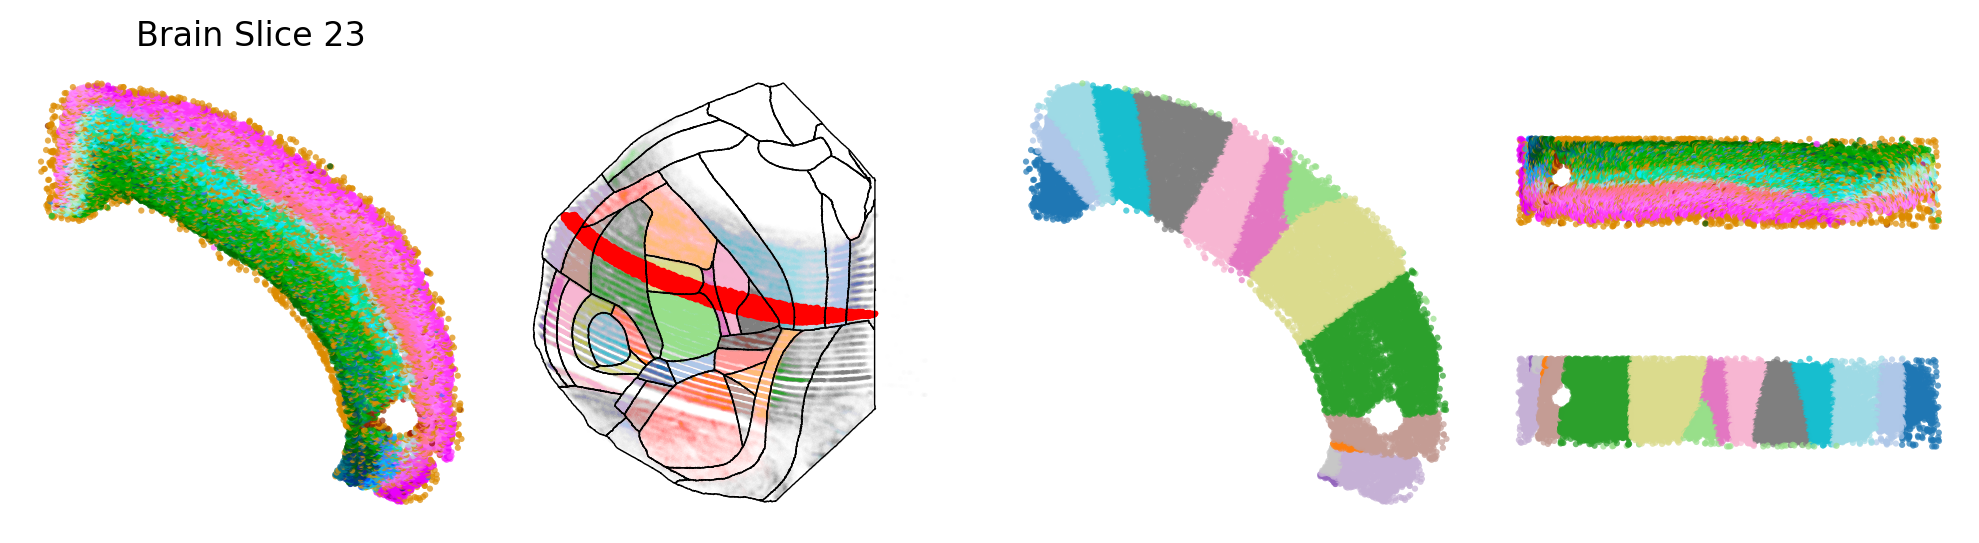

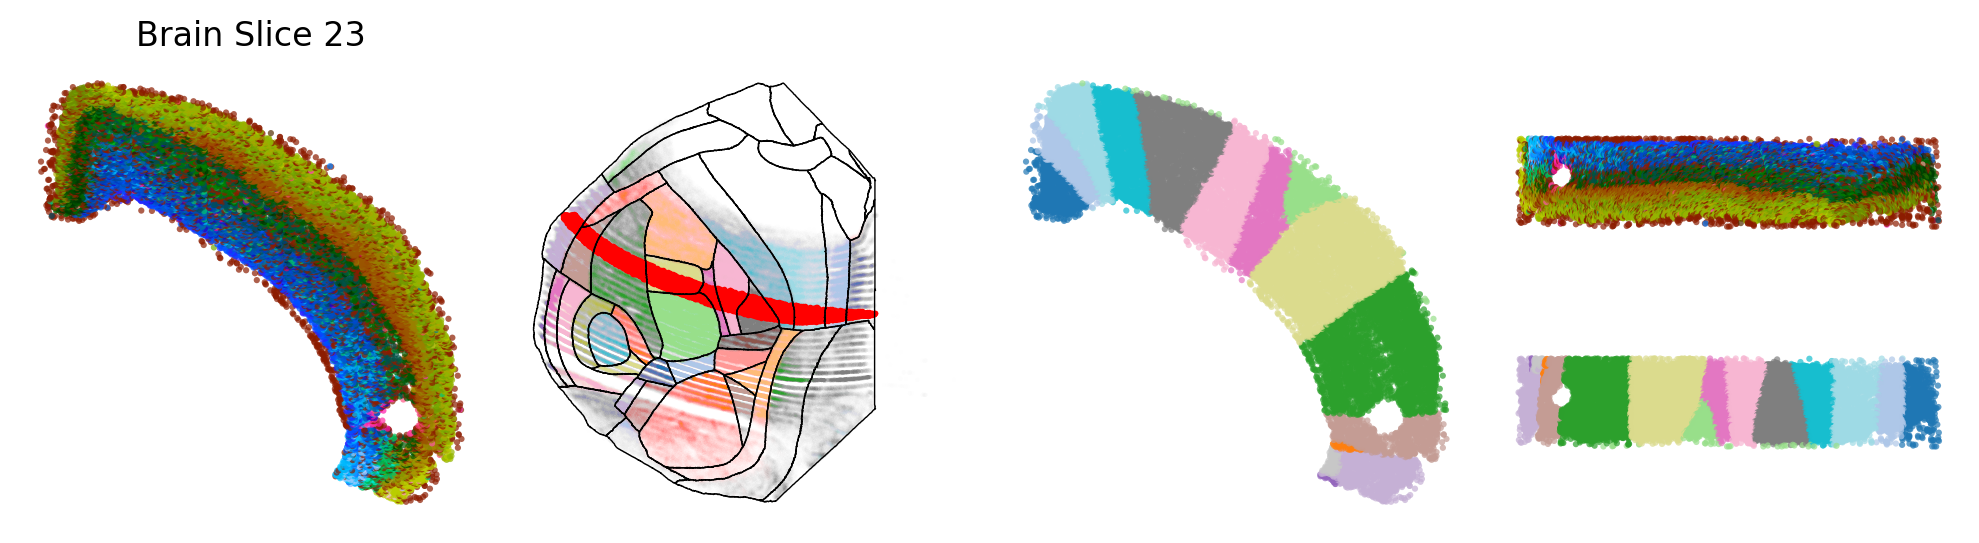

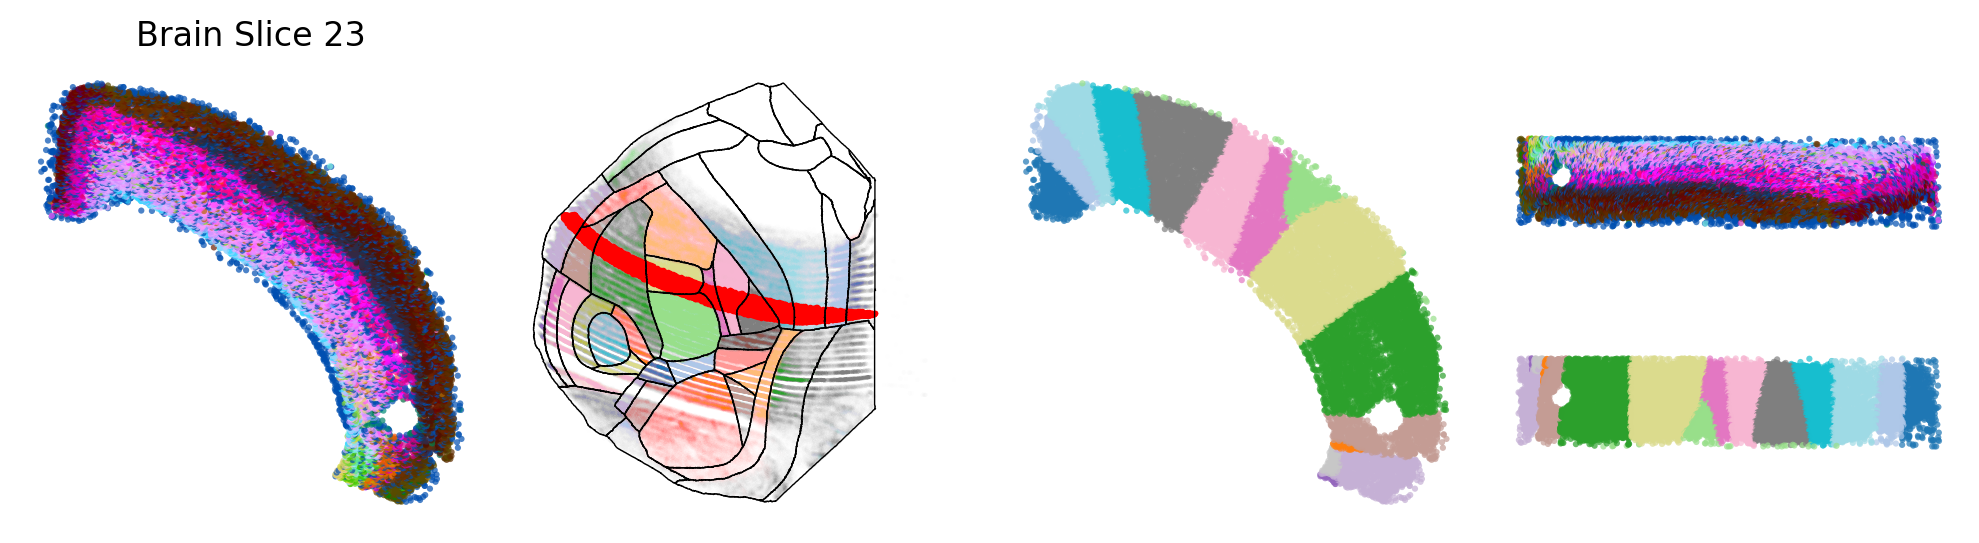

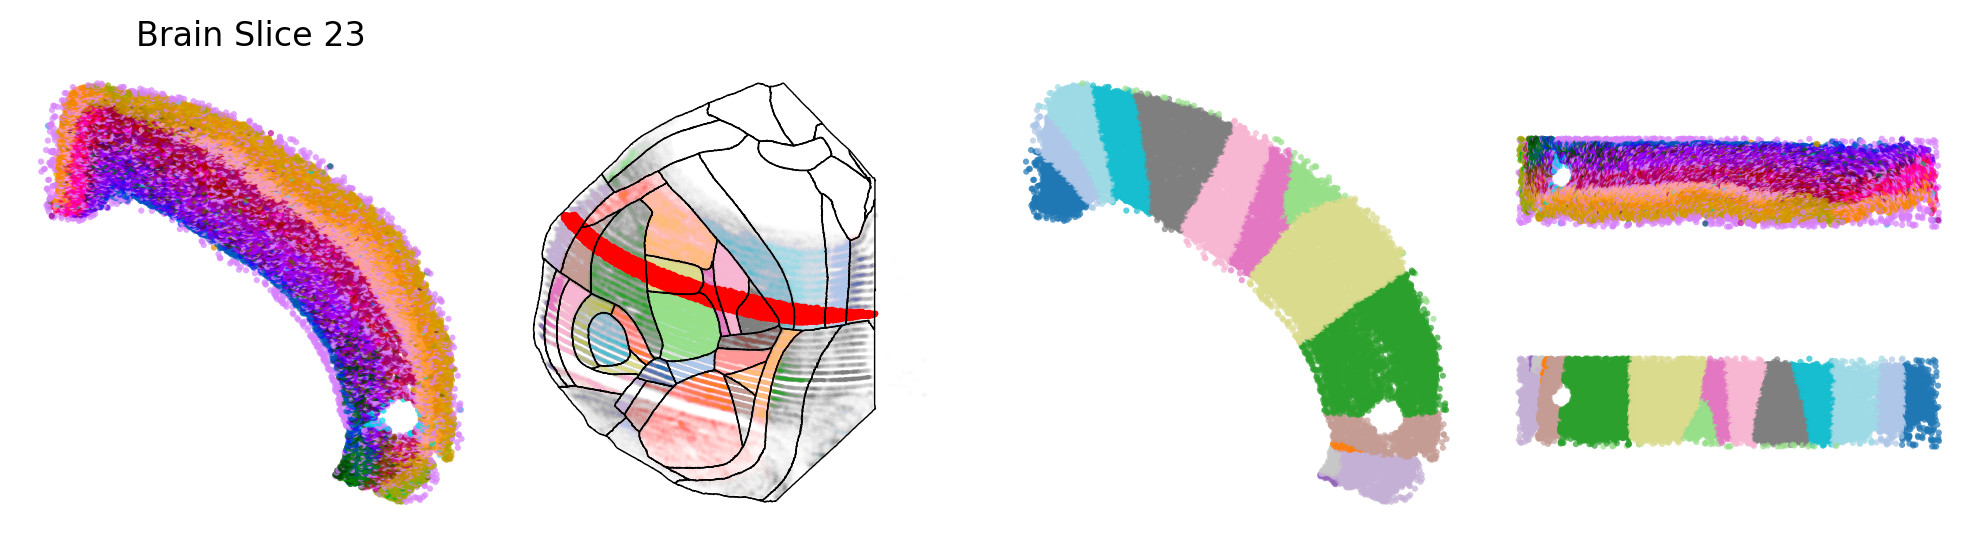

In [27]:
slice_ = 23
cmaps=[]
for _ in range(5):
    cmap = get_colormap(ann_files[0], key="H3_type")    
    cmaps.append(cmap)
    plot_slices_by_celltype(ann_files[0], slice_, (10,30),  color_map=cmap, color_by='H3_type', dpi=200)

# cmap = generate_distinct_colors(len(np.unique(a))

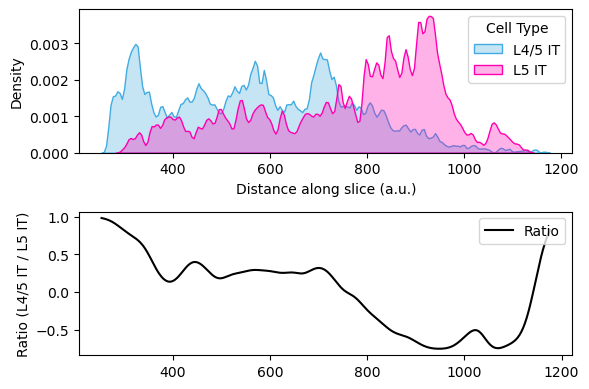

In [12]:
for slice_ in range(25,26):
    # plot_slices_by_celltype(ann_files[0], slice_, (10,30),  color_map=cmaps[4], color_by='H3_type', dpi=500)
    plot_density_by_celltype(ann_files[0], slice_, (6,4),  color_map=cmaps[4], color_by='H2_type_of_interest')

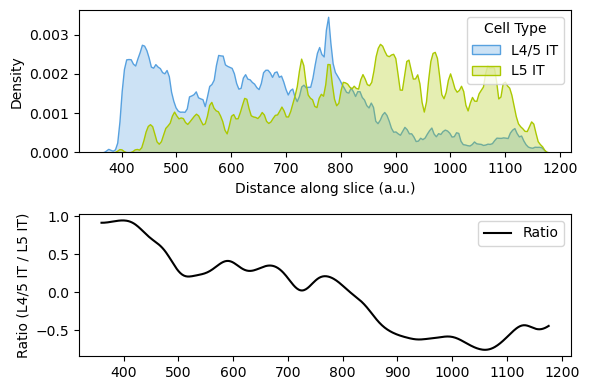

In [ ]:
for slice_ in range(23,24):
    # plot_slices_by_celltype(ann_files[2], slice, (10,30),  color_map=cmaps[4], color_by='H3_type', dpi=500)
    plot_density_by_celltype(ann_files[2], slice, (6,4),  color_map=cmaps[4], color_by='H2_type_of_interest')
    

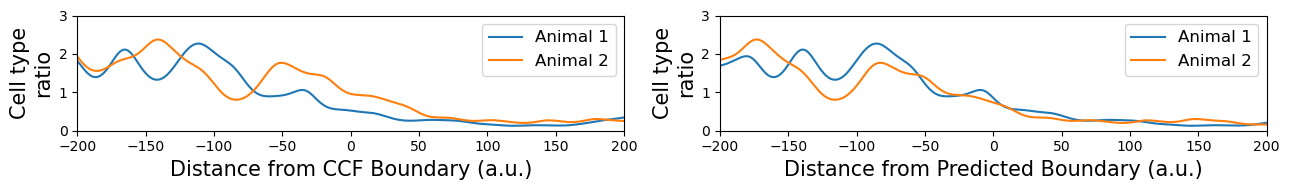

In [37]:

def plot_density_ratio_aligned(
    adatas,
    slice_nums,
    actual_predicted_boundaries,
    figsize = (10, 5),
    color_by='H2_type_of_interest',
    cell_type_names=['L4/5 IT', 'L5 IT'],
    bw=.1):

    f, ax = plt.subplots(1,2, figsize=figsize, sharey=False)
    if len(adatas) != len(slice_nums):
        raise ValueError("Number of adatas must match number of slice_nums")


    for i in range(2): #actual and predicted
        for j, adata in enumerate(adatas):
            slice_num = slice_nums[j]
            
            slice_data = adata[adata.obs['slice'] == slice_num] 
            xyz = slice_data.obsm['CCF_streamlines']
            xyz = reflect_points_to_left(xyz)
            x_ccf = xyz[:, 0]

            # offset to align the slices based on actual_predicted_boundaries
            x_ccf = x_ccf - actual_predicted_boundaries[j][i]

            cell_types = slice_data.obs[color_by]


            # Calculate KDE for both cell types on same x grid
            x_grid = np.linspace(min(x_ccf), max(x_ccf), 500)
            kde1 = stats.gaussian_kde(x_ccf[cell_types == cell_type_names[0]], bw_method=bw)
            kde2 = stats.gaussian_kde(x_ccf[cell_types == cell_type_names[1]], bw_method=bw)

            density1 = kde1(x_grid)
            density2 = kde2(x_grid)

            # Calculate ratio (with small epsilon to avoid division by zero)
            epsilon = 1e-10
            ratio = (density1 - 0*density2) / (0*density1 + density2 + epsilon)  # Normalized difference

            # Plot ratio on secondary axis
            ax[i].plot(x_grid, ratio, linewidth=1.5)
            ax[i].set_ylabel('Cell type\nratio', fontsize=15)
            ax[i].set_xlabel(f'Distance from {"CCF" if i == 0 else "Predicted"} Boundary (a.u.)', fontsize=15)
            ax[i].legend(['Animal 1', 'Animal 2'], loc='upper right', fontsize=12)
            ax[i].set_xlim(-200,200)
            ax[i].set_ylim(0,3)

    # ax[1].axis('off')     
    plt.tight_layout()
    plt.savefig(f"density_ratio_comparison.pdf")
    plt.show()

plot_density_ratio_aligned(
    [ann_files[0], ann_files[2]],  # List of AnnData objects for actual and predicted
    [25, 23],
    actual_predicted_boundaries = [[812, 800-14], #slice1, actual and predicted
                                   [800+10, 842]], #slice2, actual and predicted
    figsize = (13,2),bw=.05)

### Get predicted labels

In [155]:
def plot_slice_predictions(
    adata: ad.AnnData,
    slice_num: int,
    cell_ids: list,
    predictions: np.ndarray,
    figsize: tuple = (10, 10),
    dpi: int = 100,
    color_map = None,
    color_by: str = 'H2_type',
    legend_map: dict = None
):
    """
    Plot predictions for cells in a specific slice with proper filtering.
    
    Parameters:
    -----------
    adata: AnnData object
        Contains the cell data
    slice_num: int
        Slice number to plot
    cell_ids: list
        List of cell IDs corresponding to the predictions
    predictions: np.ndarray
        Prediction values for the cells
    figsize: tuple, default (10, 10)
        Figure size
    dpi: int, default 100
        Figure DPI
    color_map: dict, default None
        Mapping of values to colors. If None, a new color map will be created.
    color_by: str, default 'H2_type'
        Column name in adata.obs to use for coloring
    legend_map: dict, default None
        Dictionary mapping current legend labels to new labels
    
    Returns:
    --------
    fig: matplotlib.figure.Figure
        The generated figure
    """
    # Filter data for the specified slice
    slice_data = adata[adata.obs['slice'] == slice_num]
    
    # Extract coordinates
    x = slice_data.obsm['pos'][:, 0]
    y = slice_data.obsm['pos'][:, 1]
    
    # Get cell IDs for the slice
    id_s = slice_data.obs['id']
    
    # Create mapping for efficient lookup
    cell_id_to_idx = {cell_id: idx for idx, cell_id in enumerate(cell_ids)}
    
    # Get indices with -1 for missing values
    idx = [cell_id_to_idx.get(i, -1) for i in id_s]
    
    # Create mask for valid indices
    valid_mask = np.array(idx) != -1
    valid_idx = np.array(idx)[valid_mask]
    
    # Filter coordinates and predictions
    filtered_x = x[valid_mask]
    filtered_y = y[valid_mask]
    filtered_predictions = predictions[valid_idx]
    
    # Convert predictions to integers if they're class indices
    filtered_predictions = filtered_predictions.astype(int)
    
    # Create color map if not provided
    if color_map is None:
        unique_values = np.unique(filtered_predictions)
        palette = sns.color_palette("tab20", n_colors=len(unique_values))
        color_map = dict(zip(unique_values, palette))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Create the scatter plot
    if legend_map is not None:
        # Map the prediction values directly before plotting
        # Create a new array for the mapped labels
        mapped_predictions = np.array([legend_map.get(int(p), str(p)) for p in filtered_predictions])
        
        scatter = sns.scatterplot(
            x=filtered_x, 
            y=filtered_y,
            hue=mapped_predictions,  # Use the mapped predictions directly
            palette=color_map if isinstance(next(iter(color_map.keys())), str) else 
                   {legend_map.get(k, str(k)): v for k, v in color_map.items()},
            s=5,
            alpha=0.7,
            linewidth=0,
            ax=ax
        )
    else:
        scatter = sns.scatterplot(
            x=filtered_x, 
            y=filtered_y,
            hue=filtered_predictions,
            palette=color_map,
            s=5,
            alpha=0.7,
            linewidth=0,
            ax=ax
        )
    
    plt.title(f"Slice {slice_num} - Predictions")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    
    # Customize legend title
    if ax.get_legend() is not None:
        ax.get_legend().set_title("Area")
    
    return fig
    
def plot_slice_predictions_CCF(
    adata: ad.AnnData,
    slice_num: int,
    cell_ids: list,
    predictions: np.ndarray,
    figsize: tuple = (10, 10),
    dpi: int = 100,
    color_map = None,
    color_by: str = 'H2_type',
    legend_map: dict = None
):
    """
    Plot predictions for cells in a specific slice with proper filtering.
    
    Parameters:
    -----------
    adata: AnnData object
        Contains the cell data
    slice_num: int
        Slice number to plot
    cell_ids: list
        List of cell IDs corresponding to the predictions
    predictions: np.ndarray
        Prediction values for the cells
    figsize: tuple, default (10, 10)
        Figure size
    dpi: int, default 100
        Figure DPI
    color_map: dict, default None
        Mapping of values to colors. If None, a new color map will be created.
    color_by: str, default 'H2_type'
        Column name in adata.obs to use for coloring
    legend_map: dict, default None
        Dictionary mapping current legend labels to new labels
    
    Returns:
    --------
    fig: matplotlib.figure.Figure
        The generated figure
    """
    # Filter data for the specified slice
    slice_data = adata[adata.obs['slice'] == slice_num]
    
    # Extract coordinates
    xyz = slice_data.obsm['CCF_streamlines']
    xyz = reflect_points_to_left(xyz)
    x = xyz[:, 0]
    y = xyz[:, 2]
    
    # Get cell IDs for the slice
    id_s = slice_data.obs['id']
    
    # Create mapping for efficient lookup
    cell_id_to_idx = {cell_id: idx for idx, cell_id in enumerate(cell_ids)}
    
    # Get indices with -1 for missing values
    idx = [cell_id_to_idx.get(i, -1) for i in id_s]
    
    # Create mask for valid indices
    valid_mask = np.array(idx) != -1
    valid_idx = np.array(idx)[valid_mask]
    
    # Filter coordinates and predictions
    filtered_x = x[valid_mask]
    filtered_y = y[valid_mask]
    filtered_predictions = predictions[valid_idx]
    
    # Convert predictions to integers if they're class indices
    filtered_predictions = filtered_predictions.astype(int)
    
    # Create color map if not provided
    if color_map is None:
        unique_values = np.unique(filtered_predictions)
        palette = sns.color_palette("tab20", n_colors=len(unique_values))
        color_map = dict(zip(unique_values, palette))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Create the scatter plot
    if legend_map is not None:
        # Map the prediction values directly before plotting
        # Create a new array for the mapped labels
        mapped_predictions = np.array([legend_map.get(int(p), str(p)) for p in filtered_predictions])
        
        scatter = sns.scatterplot(
            x=filtered_x, 
            y=filtered_y,
            hue=mapped_predictions,  # Use the mapped predictions directly
            palette=color_map if isinstance(next(iter(color_map.keys())), str) else 
                   {legend_map.get(k, str(k)): v for k, v in color_map.items()},
            s=5,
            alpha=0.7,
            linewidth=0,
            ax=ax
        )
    else:
        scatter = sns.scatterplot(
            x=filtered_x, 
            y=filtered_y,
            hue=filtered_predictions,
            palette=color_map,
            s=5,
            alpha=0.7,
            linewidth=0,
            ax=ax
        )
    
    plt.title(f"Slice {slice_num} - Predictions")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    
    # Customize legend title
    if ax.get_legend() is not None:
        ax.get_legend().set_title("Area")
    
    return fig

In [163]:
group_size=32
val_or_test = "test"  

fold = 2    # Load data
predictions_path = os.path.join(root_path,f"barseq/annotation/fold{fold}_animal_name_class_weights2_{group_size}/{val_or_test}_brain_predictions_cells.npy")
pred_dict = np.load(predictions_path, allow_pickle=True).item()
dataset = load_from_disk(os.path.join(root_path, f"barseq/Chen2023/train_test_barseq_all_exhausted_fold{fold}.dataset"))

cell_ids = dataset['test'][pred_dict['indices']]['id']
adata = ann_files[fold]

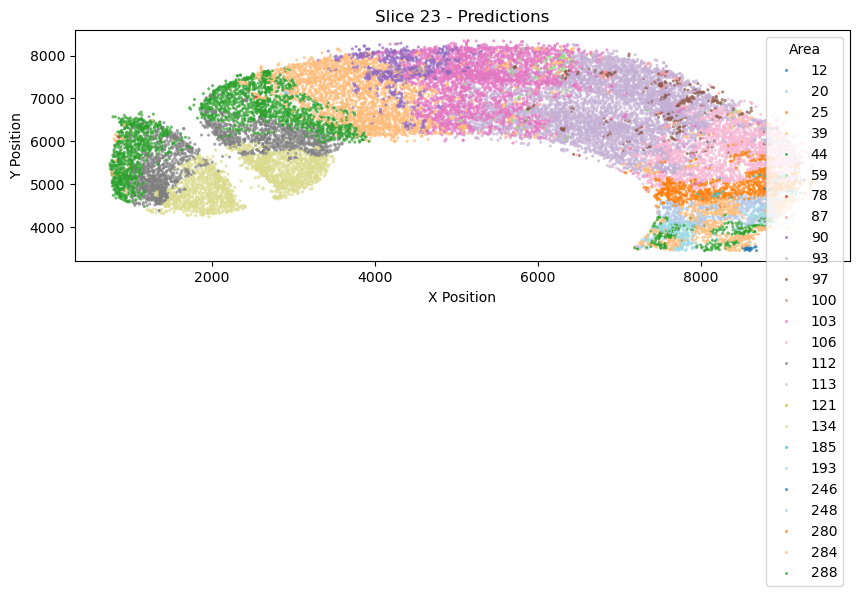

In [165]:

f = plot_slice_predictions(adata, 23, cell_ids, pred_dict['predictions'], figsize=(10,3))

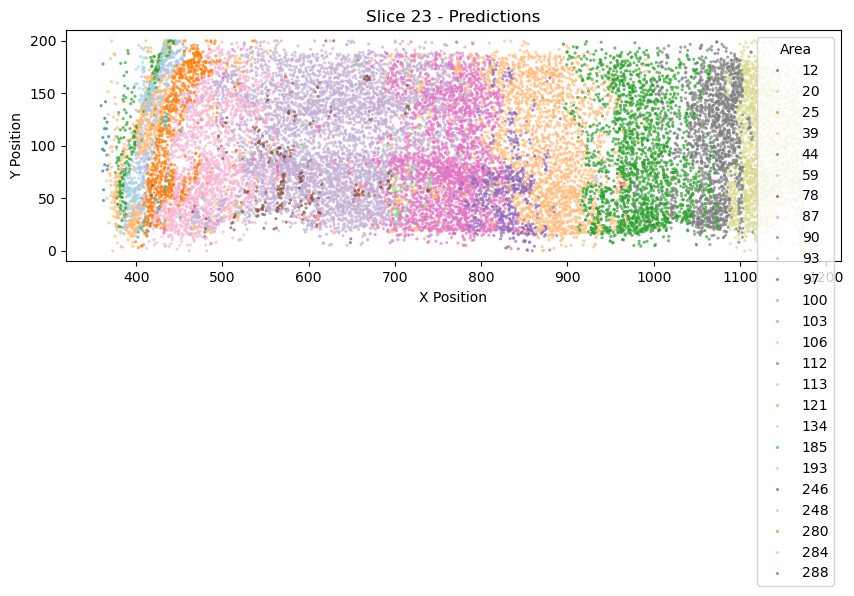

In [166]:
f = plot_slice_predictions_CCF(adata, 23, cell_ids, pred_dict['predictions'], figsize=(10,3))

/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)


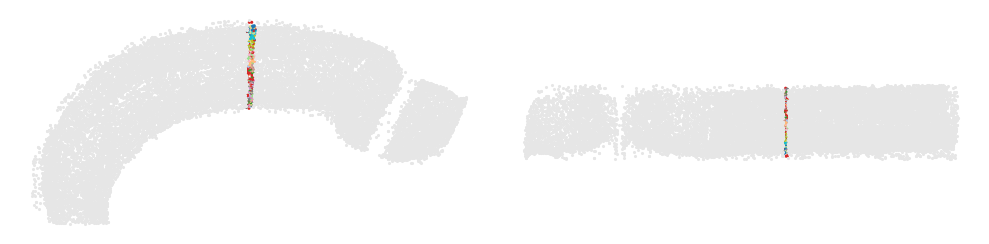

In [151]:

def plot_slices_by_celltype_cample(
    adata: ad.AnnData,
    figsize = (10, 10),
    dpi: int = 100,
    color_map = None,
    range_slices = None,
):
    """
    Plot each slice with cells colored by H2_type.
    
    Args:
        adata: AnnData object containing spatial data
        output_dir: Directory to save output plots (if None, plots are not saved)
        figsize: Figure dimensions (width, height)
        dpi: Figure resolution
        palette: Color palette to use for cell types
        
    Returns:
        Dict mapping slice numbers to matplotlib figure objects
    """
    
    # Get unique slices and H2 types
    slices = adata.obs['slice'].unique()
    cell_types = adata.obs['H3_type'].unique()
    areas = adata.obs['CCFano'].unique()
    
    # Create custom color palette if not specified
    if color_map is None:
        palette = sns.color_palette("tab20", n_colors=len(cell_types))
    
        # Create color mapping
        color_map = dict(zip(cell_types, palette))

    area_color_palette = sns.color_palette("tab20", n_colors=len(areas))
    area_color_map = dict(zip(areas, area_color_palette))
        
    # Set up figure dictionary
    figures = {}
    
    # Loop through each slice
    for slice_num in sorted(slices):
        if range_slices is not None and slice_num not in range_slices:
            continue

        # Subset data for this slice
        slice_data = adata[adata.obs['slice'] == slice_num]
        
        # Create figure
        fig, ax = plt.subplots(1,2,figsize=figsize, dpi=dpi)
        
        # Extract coordinates
        x = slice_data.obsm['pos'][:, 0]
        y = slice_data.obsm['pos'][:, 1]
        cell_types = slice_data.obs['H3_type']
        anno = slice_data.obs['CCFano']

        x_ccf = slice_data.obsm['CCF_streamlines'][:, 0]
        y_ccf = slice_data.obsm['CCF_streamlines'][:, 1]
        z_ccf = slice_data.obsm['CCF_streamlines'][:, 2]

        # get mean ccf position 
        mean_ccf = np.mean(x_ccf)
        # get nearest 64 points to mean ccf position
        points = np.argsort((x_ccf - mean_ccf)**2)[:256]
        mask = np.zeros(len(slice_data), dtype=bool)
        mask[points] = True
        
        # Create scatter plot with Seaborn
        sns.scatterplot(
            x=x[mask],
            y=y[mask],
            hue=cell_types[mask],
            palette=color_map,
            s=5,  # Point size
            linewidth=0,
            ax=ax[0]
        )
        # Create scatter plot with Seaborn
        sns.scatterplot(
            x=x[~mask],
            y=y[~mask],
            c=[.9,.9,.9],
            s=5,  # Point size
            linewidth=0,
            ax=ax[0]
        )
        
        # Formatting
        ax[0].set_xlabel("X Position")
        ax[0].set_ylabel("Y Position")
        # ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cell Type')
        ax[0].legend().remove()
        ax[0].set_aspect('equal')
        ax[0].axis('off')

        sns.scatterplot(
            x=x_ccf[mask],
            y=z_ccf[mask],
            hue=cell_types[mask],
            palette=color_map,
            s=5,  # Point size
            linewidth=0,
            ax=ax[1])
        
        sns.scatterplot(
            x=x_ccf[~mask],
            y=z_ccf[~mask],
            c=[.9,.9,.9],
            s=5,  # Point size
            linewidth=0,
            ax=ax[1])
        ax[1].legend().remove()
        ax[1].set_aspect('equal')
        ax[1].axis('off')        # Improve aesthetics
        sns.despine(fig=fig)
        plt.tight_layout()
        plt.savefig(f"ex_samples_slice_{slice_num}.png")
        plt.show()        

plot_slices_by_celltype_cample(ann_files[1], (10,20), range_slices=range(25,26), color_map=None)